In [8]:
# import all necessary modules and function defination

# import the necessary packages
!pip install 'imutils'
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from imutils import paths
import cv2
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import sys
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import pathlib
plt.style.use('ggplot')



data_dir = "./input_data/"
data_dir = pathlib.Path(data_dir)
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 100
BS = 64
momentum = 0.9
opt = SGD(lr=INIT_LR, momentum=momentum)


def load_data(data_dir):
  print("[INFO] loading images...")
  imagePaths = list(paths.list_images(data_dir))
  data = []
  labels = []
  for imagePath in imagePaths:
      label = imagePath.split(os.path.sep)[-2]
      image = cv2.imread(imagePath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (224, 224))
      
      if label == 'covid19':
          hflipped_image= np.fliplr(image)
          vflipped_image= np.flipud(image)
          data.append(hflipped_image)
          labels.append(label)
          data.append(vflipped_image)
          labels.append(label)
      data.append(image)
      labels.append(label)
  return data, labels

def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    

    
def evaluate_model(model, testX, testY):
  print("[INFO] evaluating network...")
  predIdxs = model.predict(testX, batch_size=BS)
  predIdxs = np.argmax(predIdxs, axis=1)
  cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
  print("confusion marix")
  print(cm)
  norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  df_cm = pd.DataFrame(norm_cm, index = label_encoder.inverse_transform(np.arange(3)),
                    columns = label_encoder.inverse_transform(np.arange(3)))
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True,  linewidths=.5)
  print('Accuracy Score :',accuracy_score(testY.argmax(axis=1), predIdxs))
  print('Report : ')
  print(classification_report(testY.argmax(axis=1), predIdxs))


In [ ]:
# load data, test train and split

In [3]:
data, labels = load_data(data_dir)
X = np.array(data).astype('float32') / 255.0
y = np.array(labels)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
trainX, testX, trainY, testY = train_test_split(X, y, stratify=y, test_size=0.20, random_state=19)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, test_size=0.20, random_state=19)

print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Validation: X=%s, y=%s' % (valX.shape, valY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))

[INFO] loading images...
Train: X=(904, 224, 224, 3), y=(904, 3)
Validation: X=(226, 224, 224, 3), y=(226, 3)
Test: X=(283, 224, 224, 3), y=(283, 3)


In [4]:
# load the VGG16  and use as a feature extractor
def vgg16_with_feature_extraction():
    headModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    tailModel = headModel.output
    tailModel = Flatten(name="flatten")(tailModel)
    tailModel = Dense(128, activation="relu")(tailModel)
    tailModel = BatchNormalization()(tailModel)
    tailModel = Dense(3, activation="softmax")(tailModel)
    model = Model(inputs=headModel.input, outputs=tailModel)
    for layer in headModel.layers:
        layer.trainable = False
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()

    return model

model = vgg16_with_feature_extraction()

58892288/58889256 [==============================] - 3s 0us/step
[INFO] compiling model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________

In [5]:
history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=64, validation_data=(valX, valY), verbose=2)

Train on 904 samples, validate on 226 samples
Epoch 1/100
904/904 - 9s - loss: 0.9891 - accuracy: 0.5520 - val_loss: 0.5655 - val_accuracy: 0.7743
Epoch 2/100
904/904 - 3s - loss: 0.3960 - accuracy: 0.8894 - val_loss: 0.3155 - val_accuracy: 0.8982
Epoch 3/100
904/904 - 3s - loss: 0.2488 - accuracy: 0.9347 - val_loss: 0.2289 - val_accuracy: 0.9425
Epoch 4/100
904/904 - 3s - loss: 0.1750 - accuracy: 0.9569 - val_loss: 0.1674 - val_accuracy: 0.9602
Epoch 5/100
904/904 - 3s - loss: 0.1379 - accuracy: 0.9668 - val_loss: 0.1423 - val_accuracy: 0.9823
Epoch 6/100
904/904 - 3s - loss: 0.1205 - accuracy: 0.9701 - val_loss: 0.1553 - val_accuracy: 0.9558
Epoch 7/100
904/904 - 3s - loss: 0.1152 - accuracy: 0.9746 - val_loss: 0.1467 - val_accuracy: 0.9602
Epoch 8/100
904/904 - 3s - loss: 0.1174 - accuracy: 0.9558 - val_loss: 0.1180 - val_accuracy: 0.9867
Epoch 9/100
904/904 - 3s - loss: 0.0900 - accuracy: 0.9790 - val_loss: 0.1102 - val_accuracy: 0.9867
Epoch 10/100
904/904 - 3s - loss: 0.0945 - ac

Epoch 81/100
904/904 - 3s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.9823
Epoch 82/100
904/904 - 3s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0617 - val_accuracy: 0.9779
Epoch 83/100
904/904 - 3s - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9867
Epoch 84/100
904/904 - 3s - loss: 0.0089 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9823
Epoch 85/100
904/904 - 3s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9823
Epoch 86/100
904/904 - 3s - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0582 - val_accuracy: 0.9823
Epoch 87/100
904/904 - 3s - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.0598 - val_accuracy: 0.9823
Epoch 88/100
904/904 - 3s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.0589 - val_accuracy: 0.9823
Epoch 89/100
904/904 - 3s - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9823
Epoch 90/100
904/904 - 3s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0582 - v

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


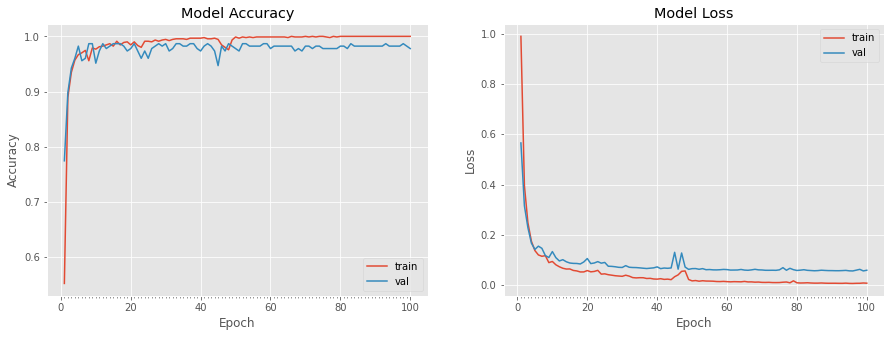

In [6]:

plot_model_history(history)

[INFO] evaluating network...
confusion marix
[[80  0  3]
 [ 0 98  2]
 [ 2  0 98]]
Accuracy Score : 0.9752650176678446
Report : 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        83
           1       1.00      0.98      0.99       100
           2       0.95      0.98      0.97       100

    accuracy                           0.98       283
   macro avg       0.98      0.97      0.98       283
weighted avg       0.98      0.98      0.98       283



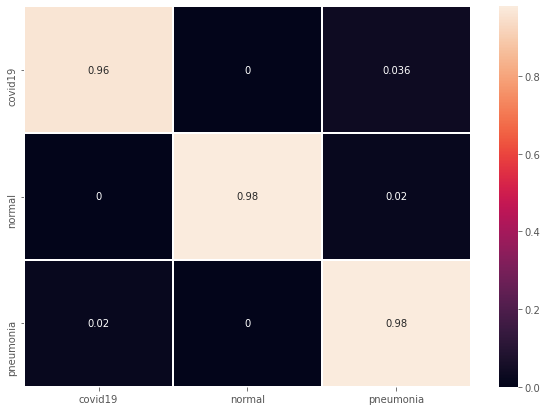

In [9]:
evaluate_model(model, testX, testY)

In [11]:
# test with VGG16 fine tunning

def vgg16_with_fineTuning():

    headModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
    tailModel = headModel.output
    tailModel = Flatten(name="flatten")(tailModel)
    tailModel = Dense(128, activation="relu")(tailModel)
    tailModel = BatchNormalization()(tailModel)
    tailModel = Dense(3, activation="softmax")(tailModel)
    model = Model(inputs=headModel.input, outputs=tailModel)
    headModel.trainable = True
    set_trainable = False
    for layer in headModel.layers:
        if layer.name in ['block5_conv1', 'block4_conv1']:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    model.summary()
    layers = [(layer, layer.name, layer.trainable) for layer in baseModel.layers]
    print(pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']))
    return model


model = vgg16_with_fineTuning()

[INFO] compiling model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (Non

In [12]:
history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=64, validation_data=(valX, valY), verbose=2)

Train on 904 samples, validate on 226 samples
Epoch 1/100
904/904 - 5s - loss: 0.8745 - accuracy: 0.5796 - val_loss: 0.3661 - val_accuracy: 0.8717
Epoch 2/100
904/904 - 4s - loss: 0.1814 - accuracy: 0.9392 - val_loss: 0.1396 - val_accuracy: 0.9646
Epoch 3/100
904/904 - 4s - loss: 0.1183 - accuracy: 0.9558 - val_loss: 0.1410 - val_accuracy: 0.9248
Epoch 4/100
904/904 - 4s - loss: 0.0548 - accuracy: 0.9812 - val_loss: 0.0942 - val_accuracy: 0.9735
Epoch 5/100
904/904 - 4s - loss: 0.0761 - accuracy: 0.9768 - val_loss: 0.1993 - val_accuracy: 0.9558
Epoch 6/100
904/904 - 4s - loss: 0.0480 - accuracy: 0.9812 - val_loss: 0.0790 - val_accuracy: 0.9867
Epoch 7/100
904/904 - 4s - loss: 0.0154 - accuracy: 0.9956 - val_loss: 0.0687 - val_accuracy: 0.9867
Epoch 8/100
904/904 - 4s - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0763 - val_accuracy: 0.9867
Epoch 9/100
904/904 - 4s - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.0613 - val_accuracy: 0.9823
Epoch 10/100
904/904 - 4s - loss: 0.0139 - ac

Epoch 79/100
904/904 - 4s - loss: 9.8583e-05 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 0.9867
Epoch 80/100
904/904 - 4s - loss: 9.7386e-05 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.9867
Epoch 81/100
904/904 - 4s - loss: 9.5897e-05 - accuracy: 1.0000 - val_loss: 0.0782 - val_accuracy: 0.9867
Epoch 82/100
904/904 - 4s - loss: 9.3666e-05 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9867
Epoch 83/100
904/904 - 4s - loss: 9.2777e-05 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.9867
Epoch 84/100
904/904 - 4s - loss: 9.0713e-05 - accuracy: 1.0000 - val_loss: 0.0790 - val_accuracy: 0.9867
Epoch 85/100
904/904 - 4s - loss: 8.9801e-05 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.9867
Epoch 86/100
904/904 - 4s - loss: 8.8496e-05 - accuracy: 1.0000 - val_loss: 0.0787 - val_accuracy: 0.9867
Epoch 87/100
904/904 - 4s - loss: 8.7177e-05 - accuracy: 1.0000 - val_loss: 0.0784 - val_accuracy: 0.9867
Epoch 88/100
904/904 - 4s - loss: 8.5910e-05 -

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:98: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:105: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


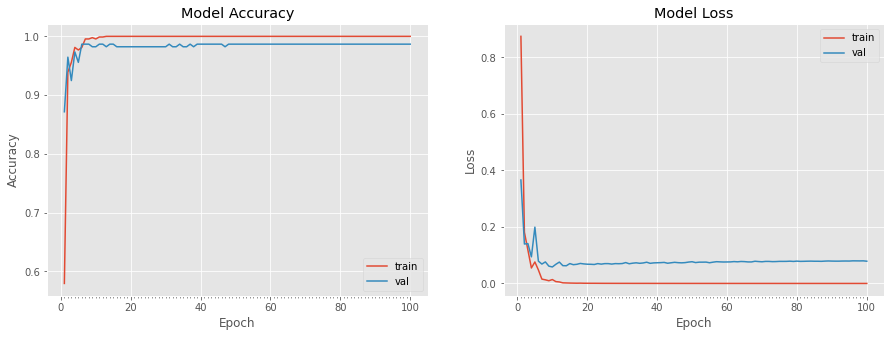

In [13]:
plot_model_history(history)

[INFO] evaluating network...
confusion marix
[[ 83   0   0]
 [  0 100   0]
 [  2   0  98]]
Accuracy Score : 0.9929328621908127
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        83
           1       1.00      1.00      1.00       100
           2       1.00      0.98      0.99       100

    accuracy                           0.99       283
   macro avg       0.99      0.99      0.99       283
weighted avg       0.99      0.99      0.99       283



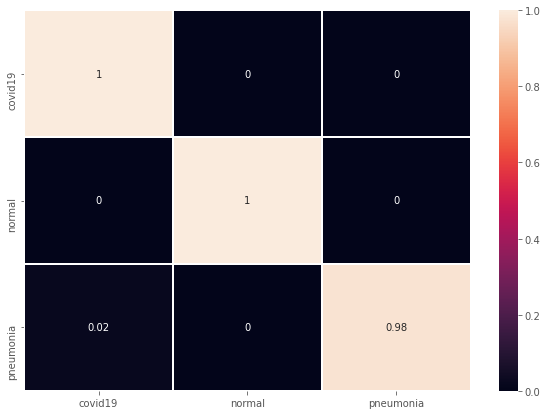

In [14]:
evaluate_model(model, testX, testY)